In [3]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import base64
import csv
import os
import seaborn as sns
import numpy as np
from glob import glob
from shutil import copyfile

%matplotlib inline

pd.set_option('display.max_columns', 100)

In [4]:
import xgboost
from xgboost import plot_importance

C:\Users\Natalia\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [96]:
# split data into X and y
X = df[ing_cols+tag_cols]
Y = df[dv1]
# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [97]:
model = XGBClassifier()
model.fit(X_train, y_train.values.ravel())

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [98]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 68.60%


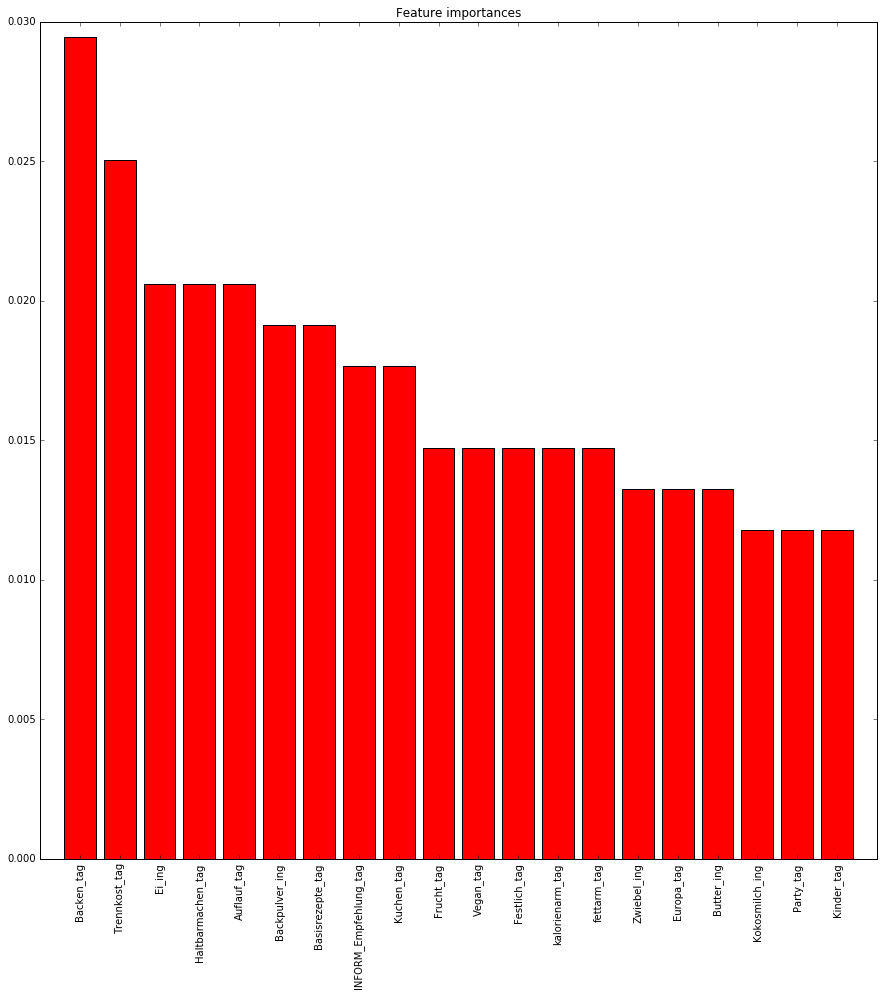

In [99]:
def feat_imp(df, model, n_features):

    d = dict(zip(df.columns, model.feature_importances_))
    ss = sorted(d, key=d.get, reverse=True)
    top_names = ss[0:n_features]

    plt.figure(figsize=(15,15))
    plt.title("Feature importances")
    plt.bar(range(n_features), [d[i] for i in top_names], color="r", align="center")
    plt.xlim(-1, n_features)
    plt.xticks(range(n_features), top_names, rotation='vertical')

feat_imp(X_train, model, 20)

In [19]:
df = pd.read_csv('dataset/recipes_df10-23-2017.csv', error_bad_lines=False, encoding='utf-8', sep = '\t')

In [20]:
df = df.dropna(axis=0, how='any')
df = df.drop_duplicates(subset = 'recipe_id')
df = df.query('date_x < "2017-09-02"')

In [21]:
df.columns = [c.replace(' ', '_') for c in df.columns]
df.columns = [c.replace('-', '_') for c in df.columns]
df.columns = [c.replace(':', '') for c in df.columns]
df['printed_total'] = np.exp(df['printed_per_day'])*df['days_exists']
df['printed_daily'] = df['printed_total']/df['days_exists']
df['log_printed_per_day'] = df['printed_per_day']

In [22]:
stars_d = df['stars'].str.get_dummies('@').add_suffix('_stars')
difficulty_d = df['difficulty'].str.get_dummies('@').add_suffix('_diff')

df = pd.concat([df,
                stars_d,
                difficulty_d],
                axis = 1)

In [23]:
threshold = df[df['has_picture'] == 'yes']['printed_per_day'].quantile(q=0.5)
np.exp(threshold)
df['num_reviews_log'] = np.log( (df['num_reviews'] + 1) / df['days_exists'] )
df['author_posts_log'] = np.log((df['author_posts'] + 1) / df['author_reg'])
df['prep_time'] = np.log(df['prep_time'])
df['label'] = (df['printed_per_day'] >= threshold)

In [24]:
df_with_pics = df[df['has_picture'] == 'yes'].copy()
threshold = df[df['has_picture'] == 'yes']['printed_per_day'].quantile(q=0.5)
np.exp(threshold)

0.31863354037267089

# Load final dataset

In [8]:
df = pd.read_csv('dataset/fin_set', error_bad_lines=False, encoding='utf-8', sep = '\t')
df_with_pics = df[df['has_picture'] == 'yes'].copy()

In [9]:
ing_cols = [col for col in df.columns if '_ing' in col]
tag_cols = [col for col in df.columns if '_tag' in col]
str_cols = [col for col in df.columns if '_stars' in col] 
dff_cols = [col for col in df.columns if '_diff' in col] 
all_cols = df.columns.values.tolist()
rest_cols = set(all_cols) - set(ing_cols) - set(tag_cols) - set(str_cols) - set(dff_cols)
rest_cols
author_inf = list(['author_reg', 'author_posts_log'])
search_inf = list(['avg_rating', 'num_reviews_log', 'prep_time', 'days_exists'] + str_cols + dff_cols)
dv1 =['label']
dv2 =['printed_per_day']
#author_inf
#other_cols = list(avg_rating, stars, num_reviews_100d, difficulty, prep_time, author_reg, author_posts_100d, days_exists, has_picture, )
#other_cols

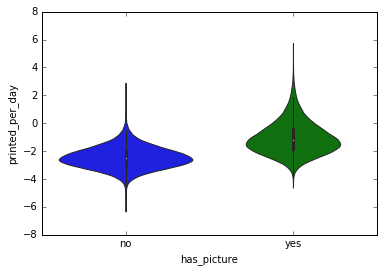

In [9]:
# Violin plot with Pokemon color palette
fig, ax =plt.subplots(1,1)
fid=sns.violinplot(x='has_picture', y='printed_per_day', data=df)
fig.savefig("visuals/has_picture.png")

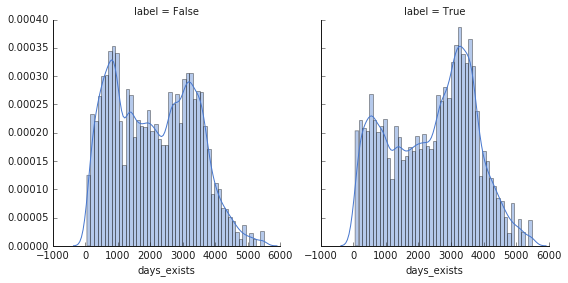

In [108]:
g = sns.FacetGrid(df_with_pics, col='label',size=4)
#plt.figure(figsize=(4,4))
g.map(sns.distplot, "days_exists")
g.savefig("visuals/days_exists.png")

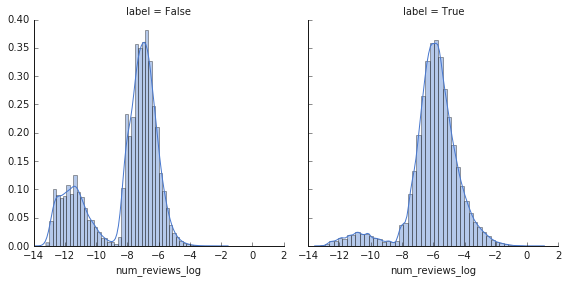

In [109]:
g = sns.FacetGrid(df_with_pics, col='label',size=4)
g.map(sns.distplot, "num_reviews_log")
g.savefig("visuals/num_reviews_log.png")

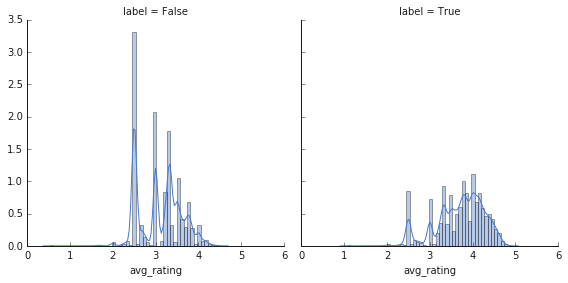

In [110]:
g = sns.FacetGrid(df_with_pics, col='label',size=4)
g.map(sns.distplot, "avg_rating")
g.savefig("visuals/avg_rating.png")

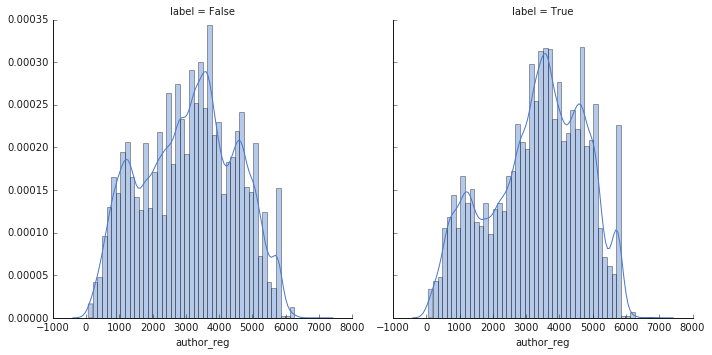

In [112]:
g = sns.FacetGrid(df_with_pics, col='label',size=5)
g.map(sns.distplot, "author_reg")
g.savefig("visuals/author_reg.png")

# Ingredients

In [34]:
list_of_lists = []

for ing in ing_cols:
    #print(tag)
    tot = df_with_pics.query('{} == 1'.format(ing))['label'].count()
    pop = df_with_pics.query('{} == 1 & label == True'.format(ing))['label'].count()
    #print(df.query('{} == 1'.format(tag))['printed_per_day'].mean())
    list_of_lists.append([ing, tot, pop])
    
ing_occurance = pd.DataFrame(list_of_lists, columns=['Ingredient', 'Total_occurance', 'Occurance_in_popular_recipes'])

In [35]:
ing_occurance['share'] = ing_occurance['Occurance_in_popular_recipes']/ing_occurance['Total_occurance']
ing_occurance_top = ing_occurance.sort_values(['share'], ascending=False).head(25).sort_values(['Total_occurance'], ascending=False)

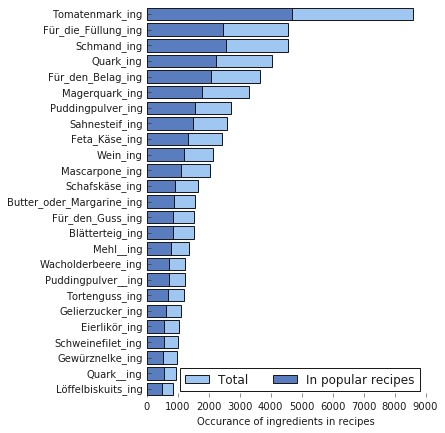

In [100]:
f, ax = plt.subplots(figsize=(5,7))

sns.set_color_codes("pastel")
sns.barplot(x="Total_occurance", y="Ingredient", data=ing_occurance_top,
            label="Total", color="b")


sns.set_color_codes("muted")
sns.barplot(x="Occurance_in_popular_recipes", y="Ingredient", data=ing_occurance_top,
            label="In popular recipes", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 9000), ylabel="",
       xlabel="Occurance of ingredients in recipes")
sns.despine(left=True, bottom=True)

f.savefig("visuals/ing.png")

# Tags

In [37]:
list_of_lists = []

for tag in tag_cols:
    #print(tag)
    tot = df_with_pics.query('{} == 1'.format(tag))['label'].count()
    pop = df_with_pics.query('{} == 1 & label == True'.format(tag))['label'].count()
    #print(df.query('{} == 1'.format(tag))['printed_per_day'].mean())
    list_of_lists.append([tag, tot, pop])
    
tag_occurance = pd.DataFrame(list_of_lists, columns=['Tag', 'Total_occurance', 'Occurance_in_popular_recipes'])

In [38]:
tag_occurance['share'] = tag_occurance['Occurance_in_popular_recipes']/ing_occurance['Total_occurance']
tag_occurance_top = tag_occurance.sort_values(['share'], ascending=False).head(25).sort_values(['Total_occurance'], ascending=False)

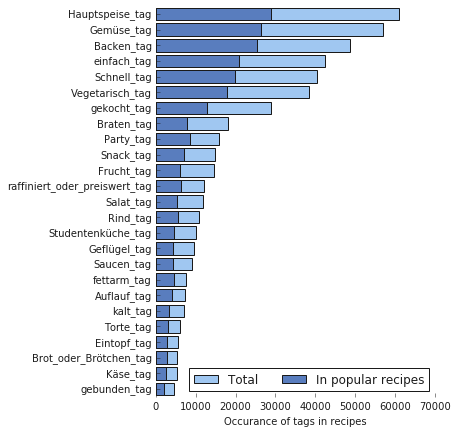

In [101]:
f, ax = plt.subplots(figsize=(5,7))

sns.set_color_codes("pastel")
sns.barplot(x="Total_occurance", y="Tag", data=tag_occurance_top,
            label="Total", color="b")


sns.set_color_codes("muted")
sns.barplot(x="Occurance_in_popular_recipes", y="Tag", data=tag_occurance_top,
            label="In popular recipes", color="b")


ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 70000), ylabel="",
       xlabel="Occurance of tags in recipes")
sns.despine(left=True, bottom=True)

f.savefig("visuals/tags.png")

In [70]:
ings_avg_pop = pd.DataFrame([avg_print_per_day_over_ing], columns=avg_print_per_day_over_ing.keys())
ings_avg_pop = pd.melt(ings_avg_pop).sort_values(['value'], ascending=False)
ings_avg_pop['prints'] = np.exp(ings_avg_pop['value'])
ings_avg_pop_top15 = ings_avg_pop.head(15)
ings_avg_pop_tail15 = ings_avg_pop.tail(15)
ings_avg_pop

,variable,value,prints
63,Löffelbiskuits_ing,-0.618978,0.538495
92,Wacholderbeere_ing,-0.659373,0.517175
13,Butter_oder_Margarine_ing,-0.708366,0.492448
217,Puddingpulver_ing,-0.723240,0.485178
220,Puddingpulver__ing,-0.727555,0.483089
163,Sahnesteif_ing,-0.730476,0.481680
216,Für_den_Belag_ing,-0.734643,0.479677
51,Quark__ing,-0.736337,0.478865
140,Schmand_ing,-0.738968,0.477606
171,Mascarpone_ing,-0.760490,0.467437


In [60]:
# df[tag_cols].apply(lambda x: df.groupby(x).agg({'printed_per_day':'mean'}).reset_index())
avg_print_per_day_over_tags = {}
for tag in tag_cols:
    #print(tag)
    m = df_with_pics.query('{} == 1'.format(tag))['printed_per_day'].mean()
    #print(df.query('{} == 1'.format(tag))['printed_per_day'].mean())
    avg_print_per_day_over_tags[tag] = m
    
avg_print_per_day_over_tags

{'Afrika_tag': -0.639861225425516,
 'Amerika_tag': -0.9039663216879766,
 'Asien_tag': -0.9182096230948729,
 'Auflauf_tag': -0.7727392937096197,
 'Aufstrich_tag': -1.0170039427678585,
 'Australien_tag': -0.8602457688758959,
 'Babynahrung_tag': -1.113598203077066,
 'Backen_oder_Süßspeise_tag': -0.6618688526744068,
 'Backen_tag': -0.8747084016866455,
 'Basisrezepte_tag': -0.5516048497099388,
 'Beilage_tag': -1.0072286903724539,
 'Belgien_tag': -0.773405968234113,
 'Blanchieren_tag': -1.3435137245239024,
 'Bowle_tag': -0.24191127423006933,
 'Braten_tag': -1.0947670401995455,
 'Brot_oder_Brötchen_tag': -0.8816551115902735,
 'Brotspeise_tag': -1.3156591089388026,
 'Camping_tag': -1.1597125669520791,
 'China_tag': -0.7872278155514749,
 'Cocktail_tag': -1.2208500327005674,
 'Creme_tag': -0.9223677245062659,
 'Dessert_tag': -1.0934394330722537,
 'Deutschland_tag': -0.7018695821593806,
 'Diabetiker_tag': -0.5824077345117811,
 'Dips_tag': -0.9910493239029831,
 'Dänemark_tag': -0.7957095110272278,

In [61]:
tags_avg_pop = pd.DataFrame([avg_print_per_day_over_tags], columns=avg_print_per_day_over_tags.keys())
tags_avg_pop = pd.melt(tags_avg_pop).sort_values(['value'], ascending=False)
tags_avg_pop['prints'] = np.exp(tags_avg_pop['value'])
tags_avg_pop_top15 = tags_avg_pop.head(15)
tags_avg_pop_tail15 = tags_avg_pop.tail(15)
tags_avg_pop

,variable,value,prints
62,INFORM_Empfehlung_tag,0.676191,1.966374
110,Trennkost_tag,-0.214888,0.806632
127,Bowle_tag,-0.241911,0.785126
26,Fondue_tag,-0.259656,0.771316
31,Halloween_tag,-0.342537,0.709967
119,Römertopf_tag,-0.441354,0.643165
90,Ägypten_tag,-0.443247,0.641948
71,Türkei_tag,-0.483734,0.616477
101,Likör_tag,-0.511954,0.599323
88,Marokko_tag,-0.515384,0.597271


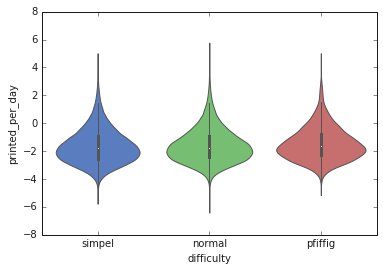

In [104]:
# Violin plot with Pokemon color palette
sns.violinplot(x='difficulty', y='printed_per_day', data=df)

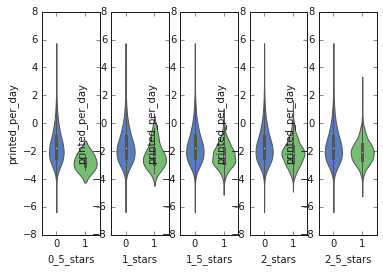

In [61]:
fig, ax = plt.subplots(1,5)
for i,tag in enumerate(str_cols[:5]):
    sns.violinplot(x=tag, y='printed_per_day', data=df, ax=ax[i])

In [48]:
df_with_pics[search_inf].describe()

,avg_rating,num_reviews_log,prep_time,days_exists,0_5_stars,1_stars,1_5_stars,2_stars,2_5_stars,3_stars,3_5_stars,4_stars,4_5_stars,5_stars,unb_stars,normal_diff,pfiffig_diff,simpel_diff
count,155452.000000,155452.000000,155452.000000,155452.000000,155452.000000,155452.000000,155452.000000,155452.000000,155452.000000,155452.000000,155452.000000,155452.000000,155452.000000,155452.000000,155452.000000,155452.000000,155452.000000,155452.000000
mean,3.407428,-7.040799,3.053354,2268.694787,0.000006,0.000058,0.000978,0.004368,0.029302,0.141722,0.325084,0.255970,0.082167,0.000778,0.159567,0.467283,0.020051,0.512666
std,0.604555,2.190992,0.628615,1283.368776,0.002536,0.007609,0.031255,0.065946,0.168651,0.348766,0.468408,0.436406,0.274620,0.027889,0.366205,0.498930,0.140176,0.499841
min,0.540000,-13.210924,0.000000,52.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,-7.576286,2.708050,1075.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.400000,-6.620405,2.995732,2363.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,3.860000,-5.730348,3.401197,3302.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,4.880000,0.730577,8.006368,5486.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
